# MobileNetV2 Fine-Tuning Phase 2 (Improved)

## Import Dependancies

In [18]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, regularizers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt
from pathlib import Path
import json
import pandas as pd


# paths, meta and data sets

In [20]:
# Load your metadata and index file (same as before)
OUT_DIR = Path("../../data/processed/FC211042_Heshani")

meta_path = OUT_DIR / "meta.json"
index_path = OUT_DIR / "index.csv"

meta = json.load(open(meta_path, "r"))
idx  = pd.read_csv(index_path)

CLASSES     = meta["selected_classes"]
LABEL2ID    = {k:int(v) for k,v in meta["LABEL2ID"].items()}
CLASS_WTS   = {int(k): float(v) for k,v in meta.get("class_weights", {}).items()}
IMG_SIZE    = int(meta.get("IMG_SIZE", 224))
SEED        = 42

# Split into train/val using the same logic as before
train_df = idx[idx["split"] == "train"].copy()
val_df   = idx[idx["split"] == "val"].copy()

# Dataset builder (copied from your first notebook)
AUTOTUNE   = tf.data.AUTOTUNE
BATCH_SIZE = 16

def decode_and_preprocess(filename, label_id):
    img = tf.io.read_file(filename)
    img = tf.io.decode_jpeg(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)
    img = tf.keras.applications.mobilenet_v2.preprocess_input(img * 255.0)
    img = tf.reshape(img, [IMG_SIZE, IMG_SIZE, 3])
    return img, label_id

def augment(img, label_id):
    img = tf.image.random_flip_left_right(img)
    return img, label_id

def df_to_ds(df_split, shuffle=True, augment_on=False):
    files  = df_split["path"].tolist()
    labels = [LABEL2ID[l] for l in df_split["label"].tolist()]
    ds = tf.data.Dataset.from_tensor_slices((files, labels))
    if shuffle:
        ds = ds.shuffle(buffer_size=len(files), seed=SEED, reshuffle_each_iteration=True)
    ds = ds.map(decode_and_preprocess, num_parallel_calls=AUTOTUNE)
    if augment_on:
        ds = ds.map(augment, num_parallel_calls=AUTOTUNE)
    return ds.batch(BATCH_SIZE).prefetch(AUTOTUNE)

# ✅ Create datasets
train_ds = df_to_ds(train_df, augment_on=True)
val_ds   = df_to_ds(val_df, shuffle=False)

print("train_ds and val_ds are ready!")

train_ds and val_ds are ready!


## Load your previously trained model

In [22]:
ckpt_dir = Path("./models")
model_path = ckpt_dir / "mobilenetv2_finetune_best.keras"  # best model from previous run
assert model_path.exists(), f"Model not found at {model_path}"

model = keras.models.load_model(model_path)
print("Loaded previous best fine-tuned model")

Loaded previous best fine-tuned model


## Add stronger regularization (to reduce overfitting)

In [23]:

for layer in model.layers:
    if isinstance(layer, layers.Dropout):
        layer.rate = 0.4  # previously 0.3, increase slightly
    if isinstance(layer, layers.Dense):
        layer.kernel_regularizer = regularizers.l2(1e-4)

In [24]:
# Unfreeze only the last few blocks 

bbase_model = None
for lyr in model.layers:
    if isinstance(lyr, tf.keras.Model) and "mobilenetv2" in lyr.name.lower():
        base_model = lyr
        break

if base_model:
    total_layers = len(base_model.layers)
    for i, lyr in enumerate(base_model.layers):
        lyr.trainable = (i >= total_layers - 20)
    print(f"Unfroze last 20 layers of base model ({base_model.name})")
else:
    print(" Could not find base model; fine-tuning skipped.")

Unfroze last 20 layers of base model (mobilenetv2_1.00_224)


In [25]:



#  Recompile with smaller learning rate 

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-5),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

# Callbacks 
callbacks = [
    EarlyStopping(monitor="val_loss", patience=3, restore_best_weights=True, verbose=1),
    ModelCheckpoint(str(ckpt_dir / "mobilenetv2_finetune_v2_best.keras"), save_best_only=True, verbose=1)
]


# Short fine-tuning 

FINE_TUNE_2_EPOCHS = 10

history_fine2 = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=FINE_TUNE_2_EPOCHS,
    class_weight=CLASS_WTS if CLASS_WTS else None,
    callbacks=callbacks,
    verbose=1
)


Epoch 1/10


1360/1360 ━━━━━━━━━━━━━━━━━━━━ 0s 269ms/step - accuracy: 0.9841 - loss: 0.0500
Epoch 1: val_loss improved from None to 1.36458, saving model to models\mobilenetv2_finetune_v2_best.keras
1360/1360 ━━━━━━━━━━━━━━━━━━━━ 417s 300ms/step - accuracy: 0.9859 - loss: 0.0460 - val_accuracy: 0.7208 - val_loss: 1.3646
Epoch 2/10
1360/1360 ━━━━━━━━━━━━━━━━━━━━ 0s 303ms/step - accuracy: 0.9875 - loss: 0.0435
Epoch 2: val_loss did not improve from 1.36458
1360/1360 ━━━━━━━━━━━━━━━━━━━━ 449s 330ms/step - accuracy: 0.9872 - loss: 0.0416 - val_accuracy: 0.7155 - val_loss: 1.3994
Epoch 3/10
1360/1360 ━━━━━━━━━━━━━━━━━━━━ 0s 367ms/step - accuracy: 0.9887 - loss: 0.0376
Epoch 3: val_loss did not improve from 1.36458
1360/1360 ━━━━━━━━━━━━━━━━━━━━ 533s 391ms/step - accuracy: 0.9885 - loss: 0.0372 - val_accuracy: 0.7225 - val_loss: 1.4331
Epoch 4/10
1360/1360 ━━━━━━━━━━━━━━━━━━━━ 0s 287ms/step - accuracy: 0.9901 - loss: 0.0339
Epoch 4: val_loss did not improve from 1.36458
1360/1360 ━━━━━━━━━━━━━━━━━━━━ 427

## Evaluate and visualize

✅ Model saved as mobilenetv2_finetune_v2_final.keras


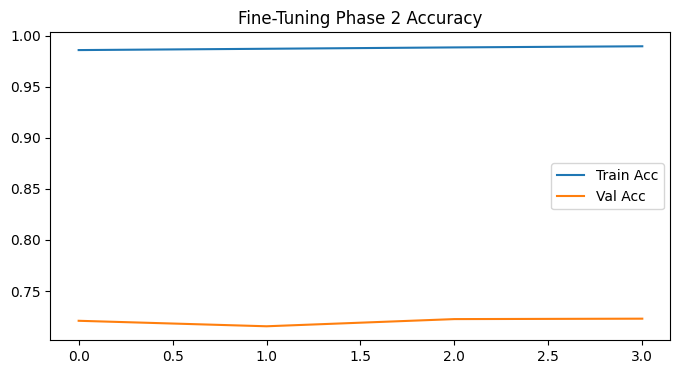

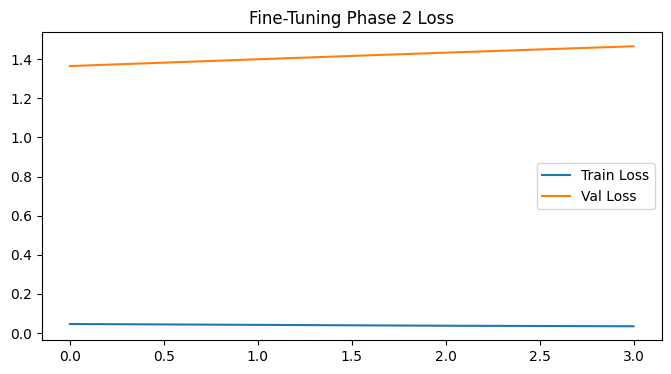

In [26]:
model.save(str(ckpt_dir / "mobilenetv2_finetune_v2_final.keras"))
print("✅ Model saved as mobilenetv2_finetune_v2_final.keras")

plt.figure(figsize=(8,4))
plt.plot(history_fine2.history["accuracy"], label="Train Acc")
plt.plot(history_fine2.history["val_accuracy"], label="Val Acc")
plt.legend(); plt.title("Fine-Tuning Phase 2 Accuracy"); plt.show()

plt.figure(figsize=(8,4))
plt.plot(history_fine2.history["loss"], label="Train Loss")
plt.plot(history_fine2.history["val_loss"], label="Val Loss")
plt.legend(); plt.title("Fine-Tuning Phase 2 Loss"); plt.show()